# 1.3.1: World Population (Abstraction)

<br>

---

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---


In the previous chapter, we used a model to optimize the design of our bikeshare system.  In this chapter, we'll turn to the other purposes for modeling: explanation and prediction.  We're going to start with a set of data (world population growth since 1950) and try to build a model that matches the data.  In other words, we want to find the "set of rules" that can be used to generate a model that matches a given system.  

<br>

Thus the abstraction step for this process is less about choosing variables (as was the case for the falling penny and bikeshare) and more about defining relationships: the "set of rules" that defines the model.  Once we have defined the rules, we can use them to generate predictions for the next 50-100 years.

<br>

But we'll have to start by learning how to import data.

In [ ]:
#@title
# Import libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


---

## Importing Population Data into Jupyter

First, we need some data.  This [Wikipedia article on world population](https://en.wikipedia.org/wiki/Estimates_of_historical_world_population) contains tables with estimates of world population from prehistory to the present, and projections for the future.

We're going to use the Pandas library, which provides functions for
working with data, to read and import the data from the tables in the article. The function we'll use is `read_html`, which can read a web page or .html file and extract data from any tables it contains. At the top of the page, we imported Pandas and gave it the shorthand `pd`.  Now we can use it like this:

In [ ]:
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/World_population_estimates.html'
# If you are using this notebook offline, you will need to upload this data
# from the Images_and_Data folder.  Comment out the line above, and uncomment the
# line below this one, and run this cell
# filename = '../Images_and_Data/Data/World_population_estimates.html'

tables = pd.read_html(filename,
                   header=0, 
                   index_col=0,
                   decimal='M')

The arguments are:

-   `filename`: The name of the file (including the directory)
    as a string (We're actually importing an .html file from my Github account rather than directly from the internet to avoid any problems with changes to the website).

-   `header`: Indicates which row of each table should be considered the
    *header*, that is, the set of labels that identify the columns. In
    this case it is the first row (numbered 0).

-   `index_col`: Indicates which column of each table should be
    considered the *index*, that is, the set of labels that identify
    the rows. In this case it is the first column, which contains the
    years.

-   `decimal`: Normally this argument is used to indicate which
    character should be considered a decimal point, because some
    conventions use a period and some use a comma. In this case we are
    abusing the feature by treating `M` as a decimal point, which allows
    some of the estimates, which are expressed in millions, to be read
    as numbers.

The result, which is assigned to `tables`, is a sequence that contains
one `DataFrame` for each table. A `DataFrame` is an object, defined by
Pandas, that represents tabular data.  We've used `DataFrame` before, to get a nice table-like output for our `Series`.  Now we'll use it for its central purpose, which is to hold multiple multi-columned tables, where each column is a `Series`.

<br>

Go ahead and open the Wikipedia page that is linked above.  You can see that there are multiple tables.  `read_html` imported and processed all of these tables, and stores them as different 'sheets' in the `DataFrame` (just like with a spreadsheet program).

<br>

To select the table we want from `tables`, we can use the bracket operator
like this.  We want the third table (i.e. the one with index number 2):

In [ ]:
table2 = tables[2]

This line selects the third table (numbered 2), which contains
population estimates from 1950 to 2016.  We can use the class function `head` to display the first few lines of the table.  If you are interested, here's the information about [the many class functions](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) that are attributes of a `DataFrame`.

In [ ]:
table2.head()

,United States Census Bureau (2017)[28],Population Reference Bureau (1973–2016)[15],United Nations Department of Economic and Social Affairs (2015)[16],Maddison (2008)[17],HYDE (2007)[24],Tanton (1994)[18],Biraben (1980)[19],McEvedy & Jones (1978)[20],Thomlinson (1975)[21],Durand (1974)[22],Clark (1967)[23]
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2.525149e+09,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2.572851e+09,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2.619292e+09,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2.665865e+09,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2.713172e+09,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A couple things to notice:

* The first column, which is labeled `Year`, is special.  It is the *index* for this `DataFrame`, which means it contains the labels for the rows.  
* Some of the values use scientific notation; for example, `2.544000e+09` is shorthand for $2.544 \cdot 10^9$ or 2.544 billion.
* `NaN` is a special value that indicates missing data (it stands for "Not a Number").
* Notice the little "magic wand" icon next to the table: Colab allows us to interact with the table directly in Jupyter if we wanted to (we won't do that now, but feel free to click the icon and see what it does--it will not change the underlying data that we've imported).

The column labels (such as "United States Census Bureau (2017)[28]") are long strings, which makes them hard to work with.  We can replace them with shorter strings like this:

In [ ]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

Now we can select a column from the `DataFrame` using the dot operator.  Here are the estimates from the United States Census Bureau:

In [ ]:
census = table2.census / 1e9

The result is a Pandas `Series`, which we are familiar with.  The number `1e9` is a shorter way to write `1000000000` or one billion.
When we divide a `Series` by a number, it divides all of the elements of the `Series`.
From here on, we'll express population estimates in terms of billions.

<br>

We can use `tail` to see the last few elements of the `Series`:

In [ ]:
census.tail()

Year
2012    7.013871
2013    7.092128
2014    7.169968
2015    7.247893
2016    7.325997
Name: census, dtype: float64

The left column is the *index* of the `Series`; in this example it contains the dates.
The right column contains the *values*, which are population estimates.
In 2016 the world population was about 7.3 billion.

<br>

Here are the estimates from the United Nations
Department of Economic and Social Affairs (U.N. DESA):

In [ ]:
un = table2.un / 1e9
un.tail()

Year
2012    7.080072
2013    7.162119
2014    7.243784
2015    7.349472
2016         NaN
Name: un, dtype: float64

The most recent estimate we have from the U.N. is for 2015, so the value for 2016 is `NaN`.

<br>

Now we can plot the estimates like this:

In [ ]:
def plot_estimates():
    census.plot(style=':', label='US Census',legend=True)
    un.plot(style='--', label='UN DESA',xlabel='Year', 
             ylabel='World population (billion)',
            title='World population Estimates',
           legend=True); 

And here's what it looks like.

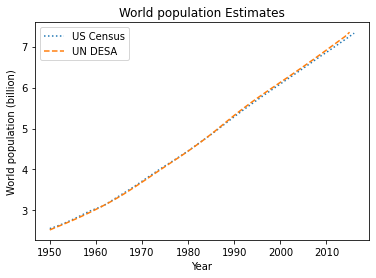

In [ ]:
plot_estimates()

The lines overlap almost completely, but the most recent estimates diverge slightly.

<br>

✅ Active Reading: Notice in the definition for the `plot_estimates` function that `.plot` is called twice to make a single graph.  Go back and write the documentation (docstring and a comment line for each line) for the function

<br>

---

## Using mathematical tools to understand data

Now that we've imported the data, we want to try to understand it: we need this understanding in order to decide what kind of model we'll use to predict future growth.  In other words, we need to know the 'rules' that population growth follows.

### Curve fitting as modeling

Curve fitting is one way that we can understand the 'rules' that a system is following.  When we fit a curve, we are trying to determine the mathematical function (that is, the 'rule') that best represents the data.

<br>

Sometimes when we fit a curve, we know what the curve should look like: that is, we know how that particular system behaves.  For instance, if we plot the kinematic equation $x = vt$, which says that the distance traveled $x$ is equal to the velocity times the times, we would expect a linear plot.  Here's a quick visualization, for instance, of a 'time vs. distance' plot for a drive from Augie to Chicago along with a linear fitted curve:

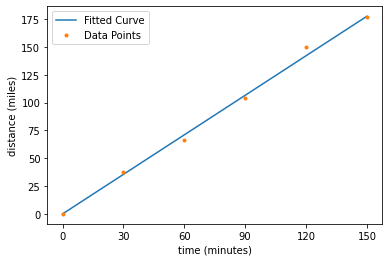

In [ ]:
#chicago_trip = pd.Series(dict(0=0,30=36,60=74,90=104,120=150,141=167),name="Trip to Chicago")
chicago_trip = pd.Series({'0':0,'30':38,'60':66,'90':104,'120':150,'150':177},name="Trip to Chicago")
linear_fit = pd.Series({'0':0,'30':35.5,'60':71.0,'90':106.5,'120':142,'150':177.5})

linear_fit.plot(label='Fitted Curve',legend='True')
chicago_trip.plot(style='.',xlabel='time (minutes)', 
        ylabel='distance (miles)', label='Data Points',legend='True'); 

In this example, we already know the 'rule' that the system follows: it is the equation $x=vt$.  In other situations, though, like world population, we don't know the rules.  So we use curve fitting to help us find the rules: if we can find a curve that matches the data, then we start to better understand the system!

<br>

As usual, we'll start simple and add complexity as we go.  Although there is some curvature in the plotted estimates, it looks like world population growth has been close to linear since 1960 or so.  To fit the model to the data, we'll compute the average annual growth
from 1950 to 2016. Since the UN and Census data are so close, we'll use the Census data.

<br>

We can select a value from a `Series` using the bracket operator:

In [ ]:
census[1950]

2.557628654

So we can get the total growth during the interval like this:

In [ ]:
total_growth = census[2016] - census[1950]
total_growth

4.768368055

In this example, the labels `2016` and `1950` are part of the data, so it
would be better not to make them part of the program. 
Putting values like these in the program is called *hard coding*; it is considered bad practice because if the data change in the future, we have to change the program.

<br>

It would be better to get the labels from the `Series`.
We can do that by selecting the index from `census` and then selecting the first element.

In [ ]:
t_0 = census.index[0]
t_0

1950

So `t_0` is the label of the first element, which is 1950.
We can get the label of the last element like this.

In [ ]:
t_end = census.index[-1]
t_end

2016

The value `-1` indicates the last element; `-2` indicates the second to last element, and so on.  The difference between `t_0` and `t_end` is the elapsed time between them.

In [ ]:
elapsed_time = t_end - t_0
elapsed_time

66

Now we can use `t_0` and `t_end` to select the population at the beginning and end of the interval.

In [ ]:
p_0 = census[t_0]
p_end = census[t_end]

And compute the total growth during the interval.

In [ ]:
total_growth = p_end - p_0
total_growth

4.768368055

Finally, we can compute average annual growth.

In [ ]:
annual_growth = total_growth / elapsed_time
annual_growth

0.07224800083333333

From 1950 to 2016, world population grew by about 0.07 billion people per year, on average.

<br>

✅ Active Reading: What is the disadvantage of including an actual value like "1950" or "0.0722" in our code (as opposed to creating a variable)?


Now we want to create a new `Series` that represents our linear model--this will be our fitted linear curve, and we can then compare it to our data.  We'll start with `p_0`,
and then add `annual_growth` each year. To store the results, we'll use a
`Series` object:

In [ ]:
results = pd.Series([],dtype=object)
results.name = 'Population'
results.index.name = 'Year'

In this example, the index and values of the `Series` are given as `Year` and `Population` to give names to the index and the values.  These names don't affect the computation, but they appear when we display or plot the `Series`.  We can set the first value in the new `Series` like this.

In [ ]:
results[t_0] = p_0

Here's what it looks like so far.

In [ ]:
pd.DataFrame(results)

,Population
Year,
1950,2.557629


Now we set the rest of the values by simulating annual growth.  The `change_func` here is simply adding the annual growth every year.  For this reason, this linear model is sometimes called a *constant growth model*.

In [ ]:
for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth

Notice:

* In a loop defined by `range`, the values of `t` go from from `t_0` to `t_end`; but while the first value is include (`t_0`) in the loop, the last one (`t_end`) is not.

* Inside the loop, we compute the population for the next year by adding the population for the current year and `annual_growth`. 

* Since `t_end = 2016`, in the last time through the loop, the value of `t` is 2015, so the last label in `results` is 2016.

Here's what the results look like, compared to the estimates.

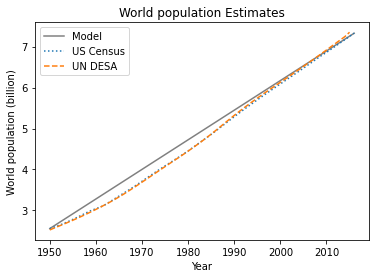

In [ ]:
results.plot(color='gray', label='Model',title='Constant Growth Model',
            legend=True)
plot_estimates()

From 1950 to 1990, the model does not fit the data particularly well, but after that, it's OK.

### Is the model correct?: Quantifying error

We've created a model here and tried to fit our model to the data.   How do we determine whether it is a good model?  

One way to characterize the "fit" of a model is *absolute error*, which is the absolute value of the difference between points in the original data and the points in our linear model.

<br>

To compute absolute error, we want to find the absolute value of the difference between each point in the two `Series`.  We can use the NumPy function `abs` and simple subtraction to find this value for each year:

In [ ]:
from numpy import abs
abs_error = abs(census - results)
abs_error.tail()

Year
2012    2.313339e-02
2013    1.712461e-02
2014    1.153252e-02
2015    5.855920e-03
2016    1.065814e-14
dtype: float64

When you subtract two `Series` objects, the result is a new `Series`.

✅ Active Reading: Why is the difference for 2016 so tiny?

Because the result is a `Series`, we can plot it without much trouble:

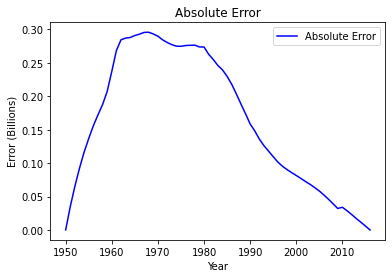

In [ ]:
abs_error.plot(color='blue', ylabel = 'Error (Billions)', label='Absolute Error',title='Absolute Error',
            legend=True);

We can use other NumPy functions to help us understand the data in this `Series`.  For instance, to summarize the results, we can compute the *mean absolute error* and *maximum absolute error*:

In [ ]:
from numpy import mean
from numpy import max

mean_abs = mean(abs_error)
max_abs = max(abs_error)
print("The average error is ", mean_abs, "billion people,")
print("while the maximum error is ", max_abs, " billion people.")

The average error is  0.16352265361940838 billion people,
while the maximum error is  0.2957788470000029  billion people.


On average, the model was off by about 0.16 billion people, and in the worst case, it was off by about 0.3 billion.  0.3 billion is a lot of people, so that might sound like a serious discrepancy.
But counting everyone is the world is hard, and we should not expect the estimates to be exact: it's still hard to tell if this is a significant error!

<br>

This is where *relative error* is helpful.  Relative error is the *percentage* difference between the values in the two `Series`.  To find this, we divide the absolute error by the estimates themselves and multiply by 100:

In [ ]:
rel_error = (abs_error / census) * 100

Now let's check out the results:

The average error is  4.109170568757119 percent, while the maximum error is  9.060605126615325  percent.
   


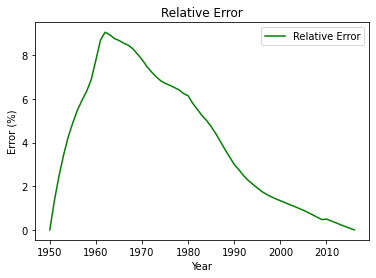

In [ ]:
rel_error.plot(color='green', ylabel = 'Error (%)', label='Relative Error',title='Relative Error',
            legend=True);
mean_rel = mean(rel_error)
max_rel = max(rel_error)
print("The average error is ", mean_rel, "percent, while the maximum error is ", max_rel, " percent.")
print("   ")

Whoa!  9% is a pretty significant error.  And notice that it's a lot easier to understand the importance of this number than the raw absolute error.  I think we're going to have to iterate our model (what a surprise! 😏 ).

You might wonder why we divided by `census` rather than `results`.
In general, if you think one data set is more accurate than the other, you put the better one in the denominator.  Here we have actual data vs. a model of that data, so we will assume that the data is more accurate.

<br>

---

## Summary

This chapter is a first step toward modeling changes in world population growth during the last 70 years.

* We used Pandas to read data from a web page and store the results in a `DataFrame`.

* Then we computed average population growth and used it to build a simple model with constant annual growth.

* We found the absolute and relative error between the model and the known census data.

* There is no obvious mechanism that could cause population growth to be constant from year to year. Changes in population are determined by the fraction of people who die and the fraction of people who give birth, so we expect them to depend on the current population.

* According to this model, world population would keep growing at the same rate forever, and that does not seem reasonable.

As you can see, fitting a curve to data can be a first step understanding data, but it doesn't really *explain* what is happening in the system.  In the next chapter we'll consider other models that might both fit the data better and make more explanatory sense.

## Exercises

Here's the code from this chapter all in one place.

In [ ]:
t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

results = pd.Series([],dtype=object)
results[t_0] = p_0

for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth

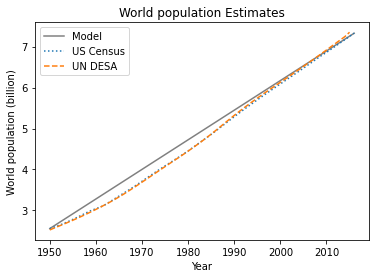

In [ ]:
results.plot(color='gray', label='Model',title='Constant Growth Model',
            legend=True)
plot_estimates()

### Exercise 1

  Try fitting the linear model using data from 1970 to the present, and see if that does a better job.

Suggestions: 

1. Define the growth constant by looking at data between 1970 and the present.  In other words, define `t_1` to be 1970 (i.e. `t1 = census.index[20]` and `p_1` to be the population in 1970.  Use `t_1` and `p_1` to compute annual growth.

2. When you create the simulation, start with the 1950 data: use `t_0` and `p_0` to run the simulation. 

3. As noted below, you might want to "shift" your model to better match the census data.


In [ ]:
# Compute the growth constant: average annual growth from 1970 to 2016
t_1 = census.index[20]
t_end = census.index[-1]
elapsed_time = t_end - t_1

p_1 = census[t_1]
p_end = census[t_end]

total_growth = p_end - p_1
annual_growth = total_growth / elapsed_time


In [ ]:
# Store model results from 1950 to the present
results = pd.Series([],dtype=object)


results[t_0] = p_0

for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth

In [ ]:
# Complete this step *after* you have plotted your results,
# and change the shift constant to improve the match between the
# model and the data
shift_constant = 0.4

# This subtracts the shift constant from each data point in the model
# Note: be careful running this cell.  If you run it twice without 
# rerunning the cell above this, you will subtract from the results
# twice
results = results - shift_constant

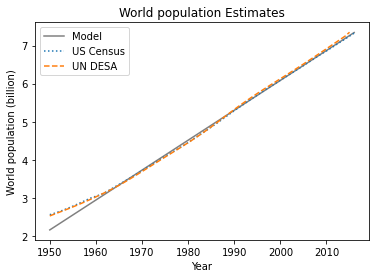

In [ ]:
# Plot results vs. actual data
results.plot(color='gray', label='Model',title='Constant Growth Model',
            legend=True)
plot_estimates()

In [ ]:
# Determine the relative error between the model and the census data
abs_error = abs(census - results)
rel_error = (abs_error/census)*100

mean_rel = mean(rel_error)
max_rel = max(rel_error)
print("The average error is ", mean_rel, "percent, while the maximum error is ", max_rel, " percent.")

The average error is  1.8547032471379685 percent, while the maximum error is  15.639486966742433  percent.


### Exercise 2

Explore the model you built in Exercise 1 until you find the `shift_constant` that creates the smallest average relative error.  Then answer these questions:

* What is the best shift constant?  
* You probably were able to get the average error down to 2% or even less.  This seems OK, right?  However, we're trying to understand population growth.   Even if a linear model fits the data, what about the nature of population growth makes it unlikely that a linear model would be accurate in the long haul?  Use your intuition to think about what kind of growth you might expect for a population.

## Bonus Exercise!!

This exercise is challenging, but I've tried to provide a lot of scaffolding to help you out.  But it is **not required**--if you've had enough coding for today, I totally understand 😀

In the previous exercise, we had to guess at the value of a shift constant and then re-guess until we found a good value.  We've done this kind of thing a couple times in the class so far.

In this exercise, set up a code to do this work for you.  To do this, you'll want to sweep through the possible values of `shift_constant` to find the lowest relative mean error.

In [ ]:
# First, we'll compute annual growth rate from 1970 to 2016 
# This shoudl be unchanged from exercise 1)
t_1 = census.index[20]
t_end = census.index[-1]
elapsed_time = t_end - t_1

p_1 = census[t_1]
p_end = census[t_end]

total_growth = p_end - p_1
annual_growth = total_growth / elapsed_time

In [ ]:
# There are multiple ways to do this.  I'll lead you through one, but
# feel free to try other options
from numpy import sum,abs,mean
# Create an empty results folder
results = pd.Series([],dtype=object)

In [ ]:
# We want to find the shift_constant that produces the smallest difference between `results` and `census`
# We'll create a variable called 'min_error'. To start we will set this
# variable very high.  We'll create another variable called 'best_shift_constant'.
# We'll set that to 0.  Then as we sweep through possible 'shift_constant' values,
# we'll replace both of our new variables anytime we find a smaller average error. 
min_error = 100
best_shift_constant = 0

# Now to sweep our parameters.   Sweep through 1000 values of 'shift_constant'
# from 0 to 1.0.
# If the average error for a given value of 'shift_constant' is lower 
# than earlier values, replace best_shift_constant with the new shift constant
# and min_error with the new minimum error

# I'll start you off with the loop:
for i in range(0,101):
    shift_constant = i/100
    results[t_0] = p_0 - shift_constant

    for t in range(t_0, t_end):
        results[t+1] = results[t] + annual_growth
    abs_error = abs(census - results)
    rel_error = (abs_error/census)*100
    mean_rel = mean(rel_error)
    if mean_rel < min_error:
        min_error = mean_rel
        best_shift_constant = shift_constant
print(best_shift_constant, min_error)

0.4 1.8547032471379898


In [ ]:
# Run simulations one more time to get the results with the best_shift_constant
# (Possibly minimal/no changes from exercise 1)
results[t_0] = p_0 - best_shift_constant

for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth



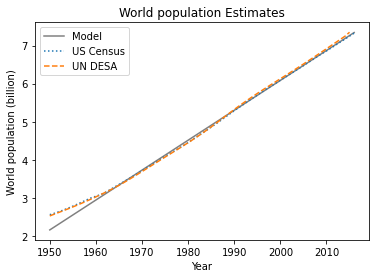

In [ ]:
# Plot results vs. actual data (no changes necessary)
results.plot(color='gray', label='Model',title='Constant Growth Model',
            legend=True)
plot_estimates()